**DATA PROCESSING**

In [3]:
import pandas as pd
import csv
import re
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0  # لتثبيت نتائج كشف اللغة

# ===============================
label_to_category = {
    0: "Internet",
    1: "Payment",
    2: "Customer Support",
    3: "Cancellation"
}

# ===============================
def split_complaints(text):
    parts = re.split(r'\s*\d+\s*[-.).:]\s*', text)
    return [p.strip() for p in parts if p.strip()]

# ===============================
data = []
with open("raw_data.txt", encoding="utf-16") as file:
    reader = csv.reader(file, delimiter=',', quotechar='"')
    next(reader)  # تجاهل الـ header
    
    for row in reader:
        if len(row) >= 2:
            text = ','.join(row[:-1]).strip()  # النص الكامل ← لو فيه فواصل داخل النص
            label = row[-1].strip()
            try:
                label = int(label)
                complaints = split_complaints(text)
                for complaint in complaints:
                    data.append({'text': complaint, 'label': label})
            except ValueError:
                print(f" problem at row→ {row}")

df = pd.DataFrame(data)

# ===============================
def generate_subject(text):
    return ' '.join(text.split()[:6]) + "..."

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

df["ticket_id"] = ["TK-" + str(i+1).zfill(5) for i in range(len(df))]
df["subject"] = df["text"].apply(generate_subject)
df["category"] = df["label"].map(label_to_category)
df["language"] = df["text"].apply(detect_language)
df["user_id"] = ["USR-" + str(i+1).zfill(5) for i in range(len(df))]
df["user_email"] = ["user" + str(i+1) + "@example.com" for i in range(len(df))]
df["password"] = ""

final_df = df[["ticket_id", "subject", "text", "category", "language", "user_id", "user_email", "password"]]

# ===============================
final_df.to_csv("support.csv", index=False, encoding="utf-8-sig")

print("Completed→ support_tickets_cleaned.csv")


Completed→ support_tickets_cleaned.csv


Samples Num : 443
Missing Values: ticket_id       0
subject         0
text            0
category        0
language        0
user_id         0
user_email      0
password      443
clean_text      0
dtype: int64


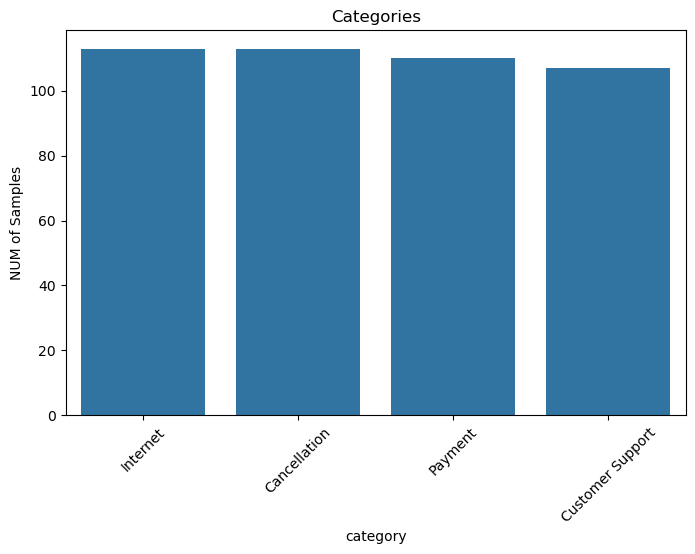

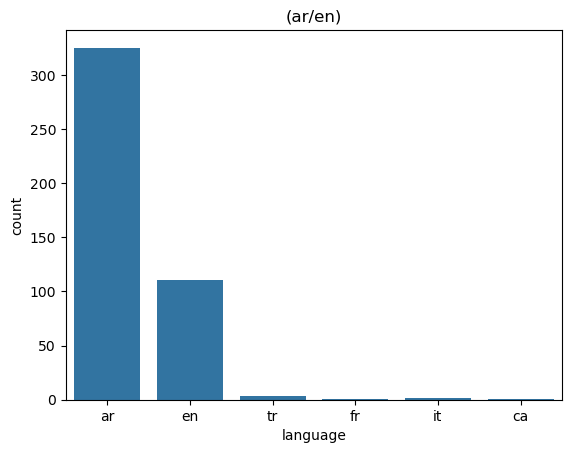


 Mean of text length 8.44920993227991

🔸 عينة من فئة: Internet
                                                  clean_text
         المهندس جي قاللي المشكلة اتحلت، بس هي لسه زي ما هي!
عامل reset للراوتر أكتر من 6 مرات النهاردة ومفيش improvement

🔸 عينة من فئة: Payment
                                              clean_text
                      الدفع من الفيزا فشل والخدمة اتوقفت
ليه كل ما أجدد لازم أدفع مرتين ويجيلي تأكيد بعد نص ساعة؟

🔸 عينة من فئة: Customer Support
                             clean_text
    ليه بتطلبوا نتواصل وانتو مش بتردوا؟
الدردشة لا تستجيب ولا حد يرد عليا live.

🔸 عينة من فئة: Cancellation
                                         clean_text
      after cancellation, الرسوم بتكرر بدون أي إذن!
مش عايز أي تواصل تاني منكم، رجاءً احذفوا كل بياناتي


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
df = pd.read_csv("support.csv")
# =========================
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\u0600-\u06FF\s?!.,]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text
df["clean_text"] = df["text"].apply(clean_text)
print ("Samples Num :", len(df))
print("Missing Values:", df.isnull().sum())

# =========================
#Categories

plt.figure(figsize=(8,5))
sns.countplot(x="category", data=df, order=df["category"].value_counts().index)
plt.title("Categories")
plt.xlabel("category")
plt.ylabel("NUM of Samples")
plt.xticks(rotation=45)
plt.show()
# =========================
#lang

sns.countplot(x="language", data=df)
plt.title("(ar/en)")
plt.show()

# =========================
# Mean of Messeg len
df["text_length"] = df["clean_text"].apply(lambda x: len(x.split()))
print("\n Mean of text length", df["text_length"].mean())
# =========================

#random sample 
for category in df["category"].unique():
    print("\n🔸 عينة من فئة:", category)
    print(df[df["category"] == category][["clean_text"]].sample(2).to_string(index=False))

**Model Training**

In [8]:
# ========================================
# 1. التحميل والتجهيز
# ========================================
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch

# ========================================
# 2. تحميل البيانات وتنظيفها
# ========================================
df = pd.read_csv("support.csv")  # ← غيّر الاسم حسب ملفك

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\u0600-\u06FF\s?!.,]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)

# تحويل الفئات إلى أرقام
label2id = {label: idx for idx, label in enumerate(df['category'].unique())}
id2label = {idx: label for label, idx in label2id.items()}
df['label'] = df['category'].map(label2id)

# ========================================
# 3. تقسيم البيانات
# ========================================
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# ========================================
# 4. تحميل النموذج والتوكنيزر
# ========================================
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label2id))

# ========================================
# 5. تحويل البيانات إلى Dataset
# ========================================
def tokenize_function(examples):
    return tokenizer(
        examples["clean_text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

train_dataset = Dataset.from_pandas(train_df[['clean_text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['clean_text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['clean_text', 'label']])

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# ========================================
# 6. دالة التقييم
# ========================================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# ========================================
# 7. إعدادات التدريب
# ========================================
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_strategy="epoch"
)

# ========================================
# 8. التدريب
# ========================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


c:\Users\LENOVO\anaconda3\envs\deepxde_env\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 12%|█▎        | 39/312 [03:36<23:40,  5.20s/it]

{'loss': 1.3873, 'grad_norm': 4.341294765472412, 'learning_rate': 2.625e-05, 'epoch': 1.0}


c:\Users\LENOVO\anaconda3\envs\deepxde_env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
                                                
 12%|█▎        | 39/312 [03:47<23:40,  5.20s/it]

{'eval_loss': 1.3266786336898804, 'eval_accuracy': 0.3787878787878788, 'eval_precision': 0.3179205851619645, 'eval_recall': 0.3787878787878788, 'eval_f1': 0.27838383838383834, 'eval_runtime': 11.3408, 'eval_samples_per_second': 5.82, 'eval_steps_per_second': 0.794, 'epoch': 1.0}


 25%|██▌       | 78/312 [1:00:50<7:40:44, 118.14s/it] 

{'loss': 1.0694, 'grad_norm': 13.941788673400879, 'learning_rate': 2.25e-05, 'epoch': 2.0}


                                                     
 25%|██▌       | 78/312 [1:00:59<7:40:44, 118.14s/it]

{'eval_loss': 0.6152306795120239, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.8442760942760944, 'eval_recall': 0.8333333333333334, 'eval_f1': 0.8356295496254927, 'eval_runtime': 8.4684, 'eval_samples_per_second': 7.794, 'eval_steps_per_second': 1.063, 'epoch': 2.0}


 38%|███▊      | 117/312 [1:03:49<13:26,  4.13s/it]  

{'loss': 0.5189, 'grad_norm': 2.8895249366760254, 'learning_rate': 1.8750000000000002e-05, 'epoch': 3.0}


                                                   
 38%|███▊      | 117/312 [1:03:57<13:26,  4.13s/it]

{'eval_loss': 0.3763023614883423, 'eval_accuracy': 0.8787878787878788, 'eval_precision': 0.8914048914048914, 'eval_recall': 0.8787878787878788, 'eval_f1': 0.879293322124538, 'eval_runtime': 7.9768, 'eval_samples_per_second': 8.274, 'eval_steps_per_second': 1.128, 'epoch': 3.0}


 50%|█████     | 156/312 [1:08:42<11:09,  4.29s/it]  

{'loss': 0.3052, 'grad_norm': 4.165955543518066, 'learning_rate': 1.5e-05, 'epoch': 4.0}


                                                   
 50%|█████     | 156/312 [1:08:51<11:09,  4.29s/it]

{'eval_loss': 0.29568105936050415, 'eval_accuracy': 0.9090909090909091, 'eval_precision': 0.9155270655270655, 'eval_recall': 0.9090909090909091, 'eval_f1': 0.9082157378041693, 'eval_runtime': 8.3804, 'eval_samples_per_second': 7.876, 'eval_steps_per_second': 1.074, 'epoch': 4.0}


 62%|██████▎   | 195/312 [1:12:20<08:39,  4.44s/it]

{'loss': 0.2139, 'grad_norm': 7.0234575271606445, 'learning_rate': 1.125e-05, 'epoch': 5.0}


                                                   
 62%|██████▎   | 195/312 [1:12:29<08:39,  4.44s/it]

{'eval_loss': 0.4120268225669861, 'eval_accuracy': 0.8636363636363636, 'eval_precision': 0.8773842319296866, 'eval_recall': 0.8636363636363636, 'eval_f1': 0.8590668818738995, 'eval_runtime': 8.5282, 'eval_samples_per_second': 7.739, 'eval_steps_per_second': 1.055, 'epoch': 5.0}


 75%|███████▌  | 234/312 [1:15:54<05:36,  4.31s/it]

{'loss': 0.1432, 'grad_norm': 0.7616057991981506, 'learning_rate': 7.5e-06, 'epoch': 6.0}


                                                   
 75%|███████▌  | 234/312 [1:16:03<05:36,  4.31s/it]

{'eval_loss': 0.31532251834869385, 'eval_accuracy': 0.9090909090909091, 'eval_precision': 0.9106331168831169, 'eval_recall': 0.9090909090909091, 'eval_f1': 0.9072146526691981, 'eval_runtime': 9.504, 'eval_samples_per_second': 6.944, 'eval_steps_per_second': 0.947, 'epoch': 6.0}


 88%|████████▊ | 273/312 [1:19:33<02:45,  4.25s/it]

{'loss': 0.0639, 'grad_norm': 0.3039476275444031, 'learning_rate': 3.75e-06, 'epoch': 7.0}


                                                   
 88%|████████▊ | 273/312 [1:19:42<02:45,  4.25s/it]

{'eval_loss': 0.23820523917675018, 'eval_accuracy': 0.9242424242424242, 'eval_precision': 0.9283459595959597, 'eval_recall': 0.9242424242424242, 'eval_f1': 0.925091870925923, 'eval_runtime': 9.2713, 'eval_samples_per_second': 7.119, 'eval_steps_per_second': 0.971, 'epoch': 7.0}


100%|██████████| 312/312 [1:23:12<00:00,  4.39s/it]

{'loss': 0.0957, 'grad_norm': 0.3186923861503601, 'learning_rate': 0.0, 'epoch': 8.0}


                                                   
100%|██████████| 312/312 [1:23:21<00:00,  4.39s/it]

{'eval_loss': 0.18077199161052704, 'eval_accuracy': 0.9393939393939394, 'eval_precision': 0.9393939393939394, 'eval_recall': 0.9393939393939394, 'eval_f1': 0.9393939393939394, 'eval_runtime': 9.2882, 'eval_samples_per_second': 7.106, 'eval_steps_per_second': 0.969, 'epoch': 8.0}


100%|██████████| 312/312 [1:24:05<00:00,  4.39s/it]

{'train_runtime': 5045.8864, 'train_samples_per_second': 0.491, 'train_steps_per_second': 0.062, 'train_loss': 0.47469106163734043, 'epoch': 8.0}


100%|██████████| 312/312 [1:24:06<00:00, 16.17s/it]


TrainOutput(global_step=312, training_loss=0.47469106163734043, metrics={'train_runtime': 5045.8864, 'train_samples_per_second': 0.491, 'train_steps_per_second': 0.062, 'total_flos': 326263567319040.0, 'train_loss': 0.47469106163734043, 'epoch': 8.0})

In [24]:
metrics = trainer.evaluate(test_dataset)
print("\n📊 Test Set Evaluation:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


100%|██████████| 9/9 [00:06<00:00,  1.43it/s]


📊 Test Set Evaluation:
eval_loss: 0.4686
eval_accuracy: 0.8955
eval_precision: 0.9075
eval_recall: 0.8955
eval_f1: 0.8949
eval_runtime: 7.1713
eval_samples_per_second: 9.3430
eval_steps_per_second: 1.2550
epoch: 8.0000


In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=False)

new_texts = [
    "مرحبا، أحتاج مساعدة في حسابي.",
    "My order hasn't arrived yet."
]

# عمل التنبؤات
predictions = classifier(new_texts)

# تحويل الأرقام لفئات أصلية
for i, pred in enumerate(predictions):
    label_id = int(pred['label'].split('_')[-1])  # label_0, label_1, ...
    label_name = id2label[label_id]
    print(f"نص: {new_texts[i]}")
    print(f"توقع الفئة: {label_name} - مع احتمال: {pred['score']:.4f}\n")


نص: مرحبا، أحتاج مساعدة في حسابي.
توقع الفئة: Customer Support - مع احتمال: 0.4794

نص: My order hasn't arrived yet.
توقع الفئة: Payment - مع احتمال: 0.9941



c:\Users\LENOVO\anaconda3\envs\deepxde_env\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


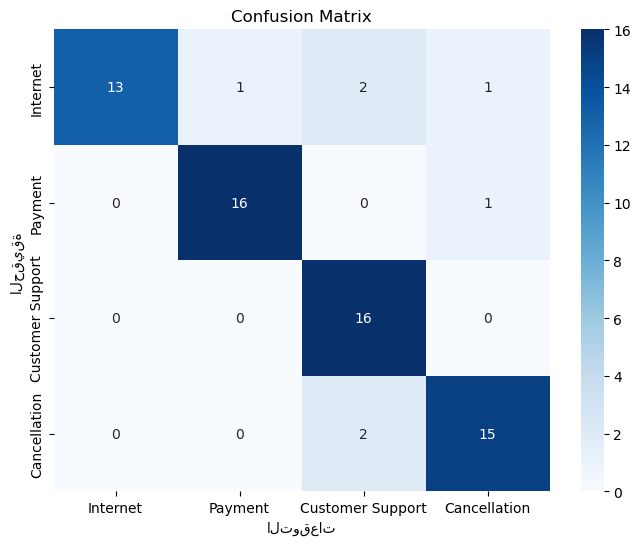

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# اجلب التوقعات على بيانات الاختبار
predictions_output = trainer.predict(test_dataset)
preds = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# حساب المصفوفة
cm = confusion_matrix(labels, preds)

# رسمها بشكل جميل
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))])
plt.xlabel('التوقعات')
plt.ylabel('الحقيقة')
plt.title('Confusion Matrix')
plt.show()


In [14]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()

inputs = {
    'input_ids': test_dataset['input_ids'],
    'attention_mask': test_dataset['attention_mask']
}

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

true_labels = test_dataset['label'].cpu().numpy()

cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix (الأرقام فقط):")
print(cm)

labels_names = [id2label[i] for i in range(len(id2label))]
print("\nLabels:")
for i, label in enumerate(labels_names):
    print(f"{i}: {label}")


Confusion Matrix (الأرقام فقط):
[[13  1  2  1]
 [ 0 16  0  1]
 [ 0  0 16  0]
 [ 0  0  2 15]]

Labels:
0: Internet
1: Payment
2: Customer Support
3: Cancellation


In [79]:
metrics = trainer.evaluate(test_dataset)
print(metrics)


100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

{'eval_loss': 0.9117445945739746, 'eval_accuracy': 0.7818181818181819, 'eval_precision': 0.7835664335664336, 'eval_recall': 0.7818181818181819, 'eval_f1': 0.7821874660584338, 'eval_runtime': 5.8566, 'eval_samples_per_second': 9.391, 'eval_steps_per_second': 1.195, 'epoch': 8.0}


In [16]:
from sklearn.metrics import classification_report

preds = trainer.predict(val_dataset)
pred_labels = np.argmax(preds.predictions, axis=1)
print(classification_report(preds.label_ids, pred_labels, target_names=label2id.keys()))


100%|██████████| 9/9 [00:06<00:00,  1.33it/s]

                  precision    recall  f1-score   support

        Internet       0.88      0.88      0.88        17
         Payment       1.00      1.00      1.00        16
Customer Support       0.88      0.88      0.88        16
    Cancellation       1.00      1.00      1.00        17

        accuracy                           0.94        66
       macro avg       0.94      0.94      0.94        66
    weighted avg       0.94      0.94      0.94        66



In [15]:
# استخراج التوقعات على مجموعة الاختبار
preds_output = trainer.predict(test_dataset)
pred_labels = np.argmax(preds_output.predictions, axis=1)
y_true = test_dataset['label']
texts = test_dataset['clean_text']  # لو عمود 'clean_text' موجود
id2label = {idx: label for label, idx in label2id.items()}

wrong = []
for text, true_label, pred_label in zip(texts, y_true, pred_labels):
    if true_label != pred_label:
        wrong.append((text, id2label[int(true_label)], id2label[int(pred_label)]))

# عرض أول 10 أمثلة خاطئة
for i, (text, actual, predicted) in enumerate(wrong[:100]):
    print(f"\n{i+1}- Text: {text}\n   Actual: {actual}\n   Predicted: {predicted}")


100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


1- Text: بعتلكم طلب رسمي ولسه مش شايف أي confirm أو sms
   Actual: Cancellation
   Predicted: Customer Support

2- Text: إزاي النت بيفصل كل خمس دقايق وأنا بدفع فلوس ع الفاضي؟
   Actual: Internet
   Predicted: Payment

3- Text: i moved to a new area and your coverage here is a joke.
   Actual: Internet
   Predicted: Cancellation

4- Text: لو في مشكلة عامة قولوا، بس ماتسكتوش والناس متعطلة ومفيش رد!
   Actual: Internet
   Predicted: Customer Support

5- Text: عندي شغل مهم بعتذر عنه كل يوم بسبب الاتصال السيء جدًا!
   Actual: Internet
   Predicted: Customer Support

6- Text: مش قادر أجدد الباقة، السيستم بيهنج
   Actual: Payment
   Predicted: Cancellation

7- Text: ليه بتاخدوا وقت طويل تلغوا الباقة؟
   Actual: Cancellation
   Predicted: Customer Support


In [23]:
# 9. تهيئة pipeline للتصنيف النصي
# ========================================
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=False,
)

# ========================================
# 10. نظام التصحيح المتقدم (AdvancedCorrectionSystem)
# ========================================
class AdvancedCorrectionSystem:
    def __init__(self):
        self.advanced_rules = {
            'Internet': {
                'primary_keywords': ['نت', 'إنترنت', 'اتصال', 'شبكة', 'internet', 'connection', 'network'],
                'secondary_keywords': ['مفصول', 'بطئ', 'ضعيف', 'منقطع', 'slow', 'weak', 'disconnected'],
                'weight': 1.0
            },
            'Payment': {
                'primary_keywords': ['دفع', 'فلوس', 'مبلغ', 'payment', 'pay', 'paid', 'amount'],
                'secondary_keywords': ['باقة', 'تجديد', 'فاتورة', 'package', 'renew', 'bill'],
                'weight': 1.2
            },
            'Customer Support': {
                'primary_keywords': ['دعم', 'مساعدة', 'support', 'help', 'service'],
                'secondary_keywords': ['رد', 'موظف', 'خدمة', 'agent', 'customer'],
                'weight': 1.1
            },
            'Cancellation': {
                'primary_keywords': ['إلغاء', 'توقف', 'cancel', 'stop', 'terminate'],
                'secondary_keywords': ['مش عايز', 'أوقف', 'انهاء', 'unsubscribe'],
                'weight': 1.3
            }
        }
        
    def calculate_category_score(self, text, category_rules):
        text_lower = text.lower()
        score = 0
        for keyword in category_rules.get('primary_keywords', []):
            if keyword in text_lower:
                score += 3
        for keyword in category_rules.get('secondary_keywords', []):
            if keyword in text_lower:
                score += 2
        weighted_score = score * category_rules.get('weight', 1.0)
        return weighted_score
    
    def advanced_predict(self, text, original_prediction, min_score_threshold=2.0):
        category_scores = {}
        for category, rules in self.advanced_rules.items():
            score = self.calculate_category_score(text, rules)
            category_scores[category] = score
        
        best_category = max(category_scores, key=category_scores.get)
        best_score = category_scores[best_category]
        
        if best_score >= min_score_threshold and best_category != original_prediction:
            return best_category, best_score, True  # تم التصحيح
        else:
            return original_prediction, best_score, False  # احتفظ بالتنبؤ الأصلي

# ========================================
# 11. التصنيف الهجين (HybridClassifier)
# ========================================
class HybridClassifier:
    def __init__(self, model_predict_func):
        """
        model_predict_func: دالة تأخذ نص أو قائمة نصوص وترجع tuple (prediction, confidence)
        """
        self.corrector = AdvancedCorrectionSystem()
        self.model_predict_func = model_predict_func
    
    def classify_text(self, text):
        original_pred, confidence = self.model_predict_func(text)
        
        corrected_pred, score, was_corrected = self.corrector.advanced_predict(text, original_pred)
        
        if was_corrected and score > 2.0:
            final_confidence = (confidence + min(score / 10, 0.95)) / 2
            method = 'corrected_by_rules'
        else:
            final_confidence = confidence
            method = 'model_only'
        
        return {
            'text': text,
            'final_prediction': corrected_pred,
            'confidence': final_confidence,
            'method': method,
            'was_corrected': was_corrected
        }

# ========================================
# 12. دالة التنبؤ التي تستخدم pipeline وتعيد التصنيف والثقة
# ========================================
def model_predict_func(text):
    outputs = classifier(text)
    # الموديل يولد لابل على شكل "LABEL_0", "LABEL_1"...
    pred_label_id = int(outputs[0]['label'].split('_')[-1])
    pred_label_name = id2label[pred_label_id]
    confidence = outputs[0]['score']
    return pred_label_name, confidence

# ========================================
# 13. استخدام المصنف الهجين على عينات نصوص
# ========================================
hybrid_classifier = HybridClassifier(model_predict_func)

texts = [
    "مش قادر أجدد الباقة السيستم بيهنج",
    "إزاي النت بيفصل كل خمس دقايق وأنا بدفع فلوس ع الفاضي؟",
    "بعتلكم طلب رسمي ولسه مش شايف أي confirm أو sms",
    "عندي مشكلة في دعم العملاء، مفيش حد بيرد",
    "عايز ألغي الاشتراك فورًا"
    "أنا عايز حد دلوقتي يتأكد إن الحساب اتقفل ومفيش تجديد تاني"
]

for text in texts:
    result = hybrid_classifier.classify_text(text)
    print(f"نص: {result['text']}")
    print(f"التصنيف النهائي: {result['final_prediction']} (طريقة: {result['method']}, ثقة: {result['confidence']:.2f})\n")

نص: مش قادر أجدد الباقة السيستم بيهنج
التصنيف النهائي: Payment (طريقة: corrected_by_rules, ثقة: 0.62)

نص: إزاي النت بيفصل كل خمس دقايق وأنا بدفع فلوس ع الفاضي؟
التصنيف النهائي: Payment (طريقة: model_only, ثقة: 1.00)

نص: بعتلكم طلب رسمي ولسه مش شايف أي confirm أو sms
التصنيف النهائي: Customer Support (طريقة: model_only, ثقة: 0.79)

نص: عندي مشكلة في دعم العملاء، مفيش حد بيرد
التصنيف النهائي: Customer Support (طريقة: model_only, ثقة: 1.00)

نص: عايز ألغي الاشتراك فورًاأنا عايز حد دلوقتي يتأكد إن الحساب اتقفل ومفيش تجديد تاني
التصنيف النهائي: Payment (طريقة: corrected_by_rules, ثقة: 0.62)

